<a href="https://colab.research.google.com/github/anggisotomani/Create-Model/blob/main/improve_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
!kaggle datasets download -d very133/dataset-flavourfinder

Dataset URL: https://www.kaggle.com/datasets/very133/dataset-flavourfinder
License(s): Community Data License Agreement - Sharing - Version 1.0
 96% 105M/110M [00:00<00:00, 240MB/s] 
100% 110M/110M [00:00<00:00, 213MB/s]


In [3]:
!unzip dataset-flavourfinder.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/chilies/Image_62_jpg.rf.46f84c05cc43c6ad7ccc38bcbf5dc402.jpg  
  inflating: dataset/chilies/Image_62_jpg.rf.ea4fa4b7f4809a197c3b3c4974ceac18.jpg  
  inflating: dataset/chilies/Image_632_jpg.rf.8c9eba8a6f1b3af1ad798bdc351826bd.jpg  
  inflating: dataset/chilies/Image_632_jpg.rf.c80c7d6996d7f7a82e88bbf33e143358.jpg  
  inflating: dataset/chilies/Image_632_jpg.rf.de50f10557fe01b546716db58a319d2f.jpg  
  inflating: dataset/chilies/Image_633_jpg.rf.124022ec54d589e0cedf045cfd9ce9f2.jpg  
  inflating: dataset/chilies/Image_633_jpg.rf.d9dc17532558e55698699e8754ad43f9.jpg  
  inflating: dataset/chilies/Image_633_jpg.rf.e4b6518a598d07d1053beb34eb6590d0.jpg  
  inflating: dataset/chilies/Image_634_jpg.rf.13804f6d498cf97db8cd5c60cf043c1c.jpg  
  inflating: dataset/chilies/Image_634_jpg.rf.1546e9397bf7ffd7cb2a00dd540aabc7.jpg  
  inflating: dataset/chilies/Image_634_jpg.rf.d59720f5af5ddb2cc867ccef5f2371b4.jpg  
  inflating: dat

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/content/dataset"

In [5]:
train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42
)

validation_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 12915 files belonging to 8 classes.
Using 10332 files for training.
Found 12915 files belonging to 8 classes.
Using 2583 files for validation.


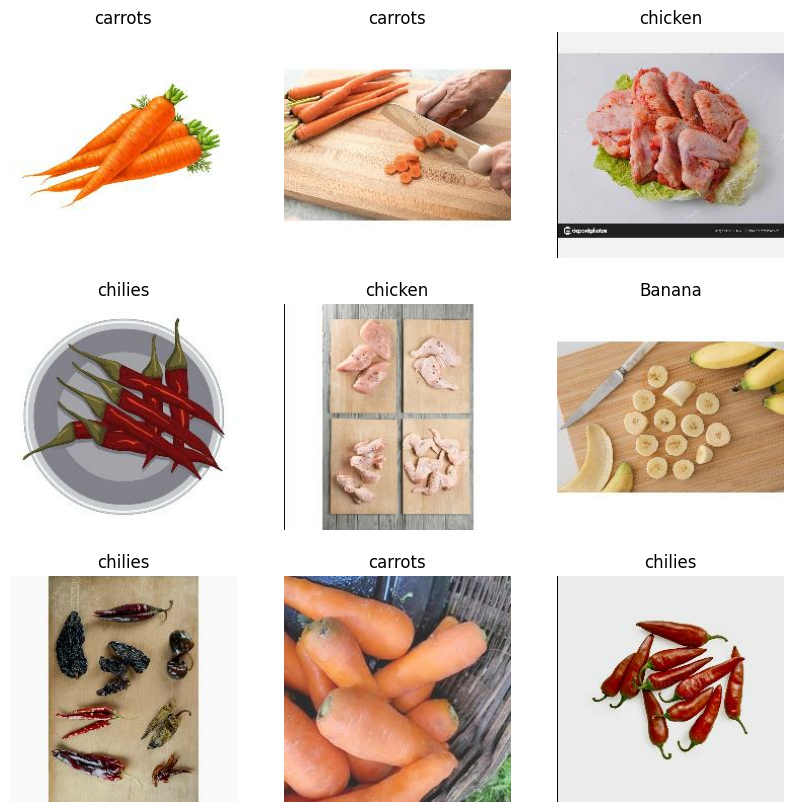

In [6]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

augmenter = data_augmenter()

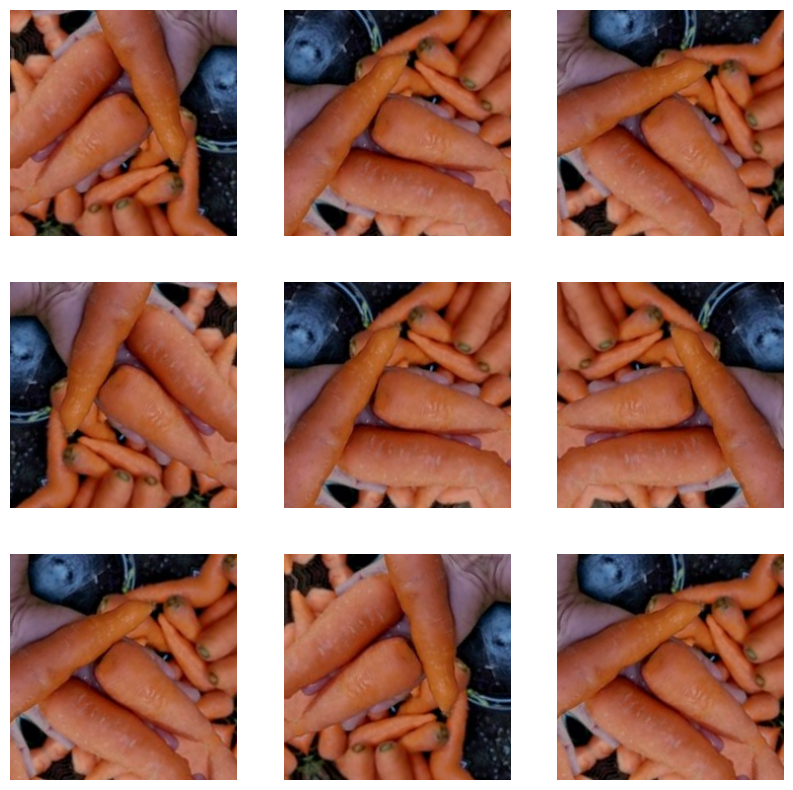

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = augmenter(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SHAPE = IMG_SIZE + (3,)

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
def ingredient_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.5)(x)
    prediction_layer = tfl.Dense(len(class_names), activation='softmax')
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model = ingredient_model(IMG_SIZE, augmenter)

In [12]:
learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [23]:
epochs = 50
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=epochs,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
323/323 [==============================] - 74s 228ms/step - loss: 0.1547 - accuracy: 0.9461 - val_loss: 0.1253 - val_accuracy: 0.9551
Epoch 2/50
323/323 [==============================] - 19s 57ms/step - loss: 0.1636 - accuracy: 0.9431 - val_loss: 0.1366 - val_accuracy: 0.9524
Epoch 3/50
323/323 [==============================] - 19s 58ms/step - loss: 0.1646 - accuracy: 0.9442 - val_loss: 0.1191 - val_accuracy: 0.9578
Epoch 4/50
323/323 [==============================] - 18s 56ms/step - loss: 0.1541 - accuracy: 0.9492 - val_loss: 0.1215 - val_accuracy: 0.9563
Epoch 5/50
323/323 [==============================] - 19s 59ms/step - loss: 0.1665 - accuracy: 0.9433 - val_loss: 0.1121 - val_accuracy: 0.9621
Epoch 6/50
323/323 [==============================] - 18s 56ms/step - loss: 0.1547 - accuracy: 0.9464 - val_loss: 0.1161 - val_accuracy: 0.9597
Epoch 7/50
323/323 [==============================] - 18s 57ms/step - loss: 0.1581 - accuracy: 0.9445 - val_loss: 0.1187 - val_accuracy

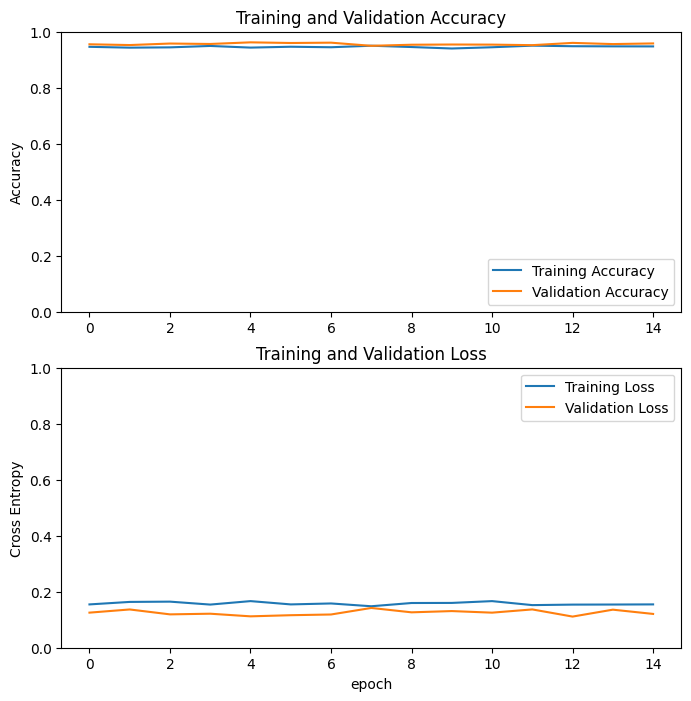

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
best_model = tf.keras.models.load_model('best_model.h5')

In [26]:
loss, accuracy = best_model.evaluate(validation_dataset)
print(f"Final validation accuracy: {accuracy}")

81/81 [==============================] - 4s 42ms/step - loss: 0.1121 - accuracy: 0.9621
Final validation accuracy: 0.9620596170425415


In [27]:
model.save('best_model.h5')

In [28]:
from google.colab import files
files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>